In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf


In [2]:
seed = 42

os.listdir('/kaggle/input/')

['cassava-leaf-disease-classification', 'cassava-leaf-disease-models']

In [20]:
images_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv', dtype = str)
images_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [21]:
images_df = images_df.sample(frac = 1, random_state = seed)
images_df.head()

,image_id,label
9134,2615227158.jpg,4
1580,1277648239.jpg,3
7304,2305895487.jpg,3
13196,336299725.jpg,2
5333,1951270318.jpg,2


In [44]:
train_folder = '/kaggle/input/cassava-leaf-disease-classification/train_images/'
images_df['image path'] = train_folder + images_df['image_id']
images_df.head()

,image_id,label,image path
9134,2615227158.jpg,4,/kaggle/input/cassava-leaf-disease-classificat...
1580,1277648239.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
7304,2305895487.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
13196,336299725.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...
5333,1951270318.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...


In [23]:
print(len(images_df))

21397


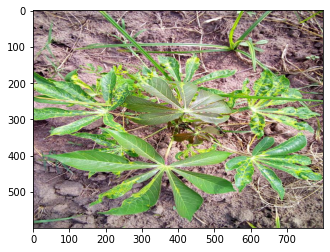

(800, 600)

In [48]:
preview = Image.open(images_df.iloc[1]['image path'])
plt.imshow(preview)
plt.show()
preview.size

In [24]:
train_val_split = 0.9
train_count = int(len(images_df) * train_val_split)
val_count = int(len(images_df) * (1 - train_val_split))
print(f'Number of training samples {train_count}')
print(f'Number of validation samples {val_count}')

Number of training samples 19257
Number of validation samples 2139


In [25]:
train_images_df = images_df[:train_count]
val_images_df = images_df[train_count:]

In [26]:
batch_size = 8
image_size = 512
input_shape = (image_size, image_size, 3)
dropout_rate = 0.5
classes_to_predict = np.sort(train_images_df['label'].unique())

In [27]:
train_images_df.astype(str)
print(train_images_df.dtypes)

image_id      object
label         object
image path    object
dtype: object


In [37]:
train_data = tf.data.Dataset.from_tensor_slices((train_images_df['image path'].values, train_images_df['label'].values))

In [32]:
#train_data = tf.data.Dataset.from_tensor_slices((train_images_df['image path'].values, train_images_df['label'].values))
#val_data = tf.data.Dataset.from_tensor_slices((val_images_df['image path'].values, val_images_df['label'].values))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                              rotation_range = 40,
                                                              width_shift_range = 0.2,
                                                              height_shift_range = 0.2,
                                                              brightness_range = (0.6, 1.2),  
                                                              shear_range = 0.2,
                                                              zoom_range = 0.2,
                                                              horizontal_flip = True,
                                                              fill_mode = 'nearest')
train_generator = train_datagen.flow_from_dataframe(train_images_df,
                                                   directory = train_folder,
                                                   x_col = 'image_id',
                                                   y_col = 'label',
                                                   target_size = (image_size, image_size),
                                                   color_mode = 'rgb',
                                                   class_mode = 'sparse',
                                                   batch_size = batch_size)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_dataframe(val_images_df,
                                               directory = train_folder,
                                               x_col = 'image_id',
                                               y_col = 'label',
                                               target_size = (image_size, image_size),
                                               color_mode = 'rgb',
                                               class_mode = 'sparse',
                                               batch_size = batch_size)

Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.


In [33]:
autotune = tf.data.AUTOTUNE
print(autotune)

-1


In [40]:
print(type(train_data))
print(type(train_generator))
print(type(train_datagen))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.keras.preprocessing.image.DataFrameIterator'>
<class 'tensorflow.python.keras.preprocessing.image.ImageDataGenerator'>


In [35]:
def load_image_and_label_from_path(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    return image, label

train_data = train_generator.map(load_image_and_label_from_path, num_parallel_calls = autotune)
val_data = val_generator.map(load_image_and_label_from_path, num_parallel_calls = autotune)

AttributeError: 'DataFrameIterator' object has no attribute 'map'

In [34]:
train_data_batches = train_data.shuffle(buffer_size = 1000).batch(batch_size = batch_size).prefetch(buffer_size = autotune)
val_data_batches = val_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)

NameError: name 'train_data' is not defined